##Load Data

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
main_path = "/content/gdrive/MyDrive/Chicken Health and Behavior Detection"
destination_path = '/content'

In [8]:
!cp "{main_path}/data/processed/audio_datasets/Poultry_Vocalization_Signal_Dataset_for_Early_Disease_Detection.zip" "{destination_path}"

In [9]:
!unzip -q "{destination_path}/Poultry_Vocalization_Signal_Dataset_for_Early_Disease_Detection.zip" -d "{destination_path}"

## EDA - Class Distribution

In [10]:
import os
import matplotlib.pyplot as plt

{'Healthy': 139, 'Noise': 86, 'Unhealthy': 121}


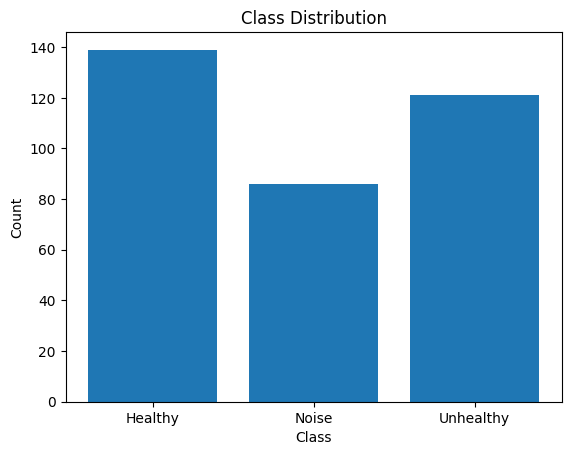

In [13]:
base_path = f'{destination_path}/Poultry Vocalization Signal Dataset for Early Disease┬аDetection/Chicken_Audio_Dataset'
classes = ['Healthy', 'Noise', 'Unhealthy']

class_counts = {cls: len(os.listdir(os.path.join(base_path, cls))) for cls in classes}

print(class_counts)
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [14]:
import librosa
import numpy as np

In [15]:
def plot_waveform(wav, sr, title='Waveform'):
  """
  plot_waveform : fungsi untuk menampilkan waveform dari file audio.

  Args:
    wav (numpy.ndarray) : array dari file audio.
    sr (int) : sampling rate dari file audio.
    title (str) : judul dari plot.

  Returns:
    None, Plot akan ditampilkan.
  """
  plt.figure(figsize=(10, 3))
  librosa.display.waveshow(wav, sr=sr)
  plt.title(title)
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')
  plt.show()

### Audio to Log-Mel Spectogram

Sebuah metode yang digunakan untuk melakukan preprocessing audio untuk memungkinkan komputer "melihat" dan "memahami" suara dengna cara yang lebih mirip dengan bagaimana manusia mendengarnya.

In [16]:
#Inisialisasi ukuran sampel, segmentation size, frequensi maksimum
SAMPLE_RATE = 22050
WAV_SIZE = int(1.5 * SAMPLE_RATE) # ~1.5 seconds at 22050 Hz
MEL_BANDS = 128
N_FFT = 2048
HOP_LENGTH = 256
N_MELS = 128

In [17]:
def audio_to_log_mel_spec(filepath):
  """
  audio_to_log_mel_spec : mengubah file audio menjadi representasi Log-Mel Spectogram.

  Args:
    filepath (str) : path dari file audio.

  Returns:
    mel_spec_db (numpy.ndarray) : representasi Log-Mel Spectogram dari file audio.
  """
  wav, sr = librosa.load(filepath, sr=SAMPLE_RATE)
  wav = librosa.util.normalize(wav)

  if len(wav) > WAV_SIZE:
    wav = wav[:WAV_SIZE]
  else:
    wav = np.pad(wav, (0, max(0, WAV_SIZE - len(wav))), "constant")

  mel_spec = librosa.feature.melspectrogram(y=wav, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=MEL_BANDS)
  mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

  return wav, mel_spec_db

In [18]:
wav, mel_spec_db = audio_to_log_mel_spec(f'{main_path}/data/processed/audio_test.mp3')

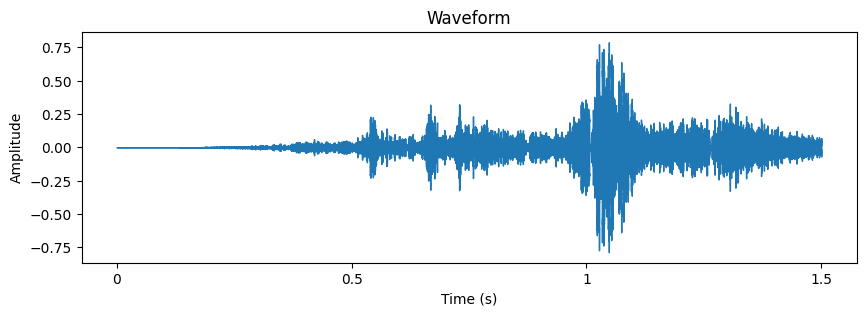

In [19]:
plot_waveform(wav, SAMPLE_RATE)

## Data Preparation

In [20]:
import torch
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm

In [21]:
file_paths = []
labels = []

for idx, cls in enumerate(classes):
  for file in os.listdir(os.path.join(base_path, cls)):
    file_paths.append(os.path.join(base_path, cls, file))
    labels.append(idx)

#Melakukan shuffle pada data
idxs = np.random.permutation(len(file_paths))
file_paths = np.array(file_paths)[idxs]
labels = np.array(labels)[idxs]

X_train, X_test, y_train, y_test = train_test_split(file_paths, labels, test_size=0.2, random_state=27)

### Data Preprocessing

In [22]:
def preprocess_audios(file_paths, labels):
  """
  preprocess_audios : mengubah file audio menjadi representasi Log-Mel Spectogram.

  Args:
    file_paths (list) : list dari path dari file audio.
    labels (list) : list dari label dari file audio.

  Returns:
    X (numpy.ndarray) : representasi Log-Mel Spectogram dari file audio.
    Y (numpy.ndarray) : label dari file audio.
  """
  X, Y = [], []
  for path, label in tqdm(zip(file_paths, labels), total = len(file_paths)):
    try:
      wav, spec = audio_to_log_mel_spec(path)
      X.append(spec)
      Y.append(label)
    except Exception as e:
      print(f"Error processing {path}: {e}")
  return np.array(X), np.array(Y)

In [33]:
X_train, y_train_np = preprocess_audios(X_train, y_train)
X_test, y_test_np = preprocess_audios(X_test, y_test)

100%|██████████| 70/70 [00:03<00:00, 21.69it/s]


In [34]:
X_train_tensor = torch.tensor(X_train).unsqueeze(1)
X_test_tensor = torch.tensor(X_test).unsqueeze(1)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_np, dtype=torch.long)

In [35]:
print(X_train_tensor.shape)

torch.Size([276, 1, 128, 130])


## Model Building

In [36]:
import torch.nn as nn

### Baseline

In [37]:
class BaselineModel(nn.Module):
  def __init__(self, num_classes=3):
    super(BaselineModel, self).__init__()

    self.features = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(32, 64, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(2),
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(59520, 64),
        nn.ReLU(),
        nn.Linear(64, num_classes)
    )

  def forward(self, x):
    x = self.features(x)
    return self.classifier(x)

## Train Model

In [38]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn.functional as F

In [39]:
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

In [40]:
train_load = DataLoader(train_ds, batch_size=32, shuffle=True)
test_load = DataLoader(test_ds, batch_size=32)

In [41]:
#Inisialisasi Model
baseline_model = BaselineModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
baseline_model.to(device)

BaselineModel(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=59520, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=3, bias=True)
  )
)

In [42]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)

### Train function

In [43]:
def train_function(model, train_loader, criterion, optimizer, epochs=30):
  """
  train_function : fungsi untuk melatih model.

  Args:
    model (nn.Module) : model yang akan dilatih.
    train_loader (DataLoader) : dataloader dari data training.
    criterion (nn.Module) : fungsi loss yang akan digunakan.
    optimizer (torch.optim) : optimizer yang akan digunakan.
    epochs (int) : jumlah epoch yang akan dilatih.

  Returns:
    None, Setiap Epochs akan mencetak loss dan akurasi dari model.
  """
  model.train()
  for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      _, preds = outputs.max(1)
      total += labels.size(0)
      correct += preds.eq(labels).sum().item()

      running_loss += loss.item()

    print(f'Epoch {epoch+1} | Loss: {running_loss:.4f} | Acc: {correct/total*100:.2f}%')

In [ ]:
train_function(baseline_model, train_load, criterion, optimizer, epochs=30)

Epoch 1 | Loss: 444.8674 | Acc: 34.42%
Epoch 2 | Loss: 25.7926 | Acc: 33.70%
Epoch 3 | Loss: 9.7131 | Acc: 43.84%
Epoch 4 | Loss: 11.2782 | Acc: 38.77%
Epoch 5 | Loss: 9.7875 | Acc: 40.58%
Epoch 6 | Loss: 9.6726 | Acc: 44.57%
Epoch 7 | Loss: 9.1377 | Acc: 53.26%
Epoch 8 | Loss: 7.5087 | Acc: 60.87%
Epoch 9 | Loss: 5.3548 | Acc: 71.01%
Epoch 10 | Loss: 4.6283 | Acc: 78.99%
Epoch 11 | Loss: 2.4365 | Acc: 90.22%
Epoch 12 | Loss: 2.2484 | Acc: 90.94%
Epoch 13 | Loss: 1.3818 | Acc: 95.65%
Epoch 14 | Loss: 0.6721 | Acc: 97.83%
Epoch 15 | Loss: 0.5229 | Acc: 99.28%
Epoch 16 | Loss: 0.4758 | Acc: 98.91%
Epoch 17 | Loss: 0.2195 | Acc: 100.00%
Epoch 18 | Loss: 0.0812 | Acc: 100.00%
Epoch 19 | Loss: 0.0475 | Acc: 100.00%
Epoch 20 | Loss: 0.0192 | Acc: 100.00%
Epoch 21 | Loss: 0.0159 | Acc: 100.00%
Epoch 22 | Loss: 0.0112 | Acc: 100.00%
Epoch 23 | Loss: 0.0101 | Acc: 100.00%
Epoch 24 | Loss: 0.0082 | Acc: 100.00%
Epoch 25 | Loss: 0.0072 | Acc: 100.00%
Epoch 26 | Loss: 0.0062 | Acc: 100.00%
Epoch 2

## Evaluate Model

In [44]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [45]:
def evaluate_model(model, test_loader, classes):
  """
  evaluate_model : fungsi untuk mengevaluasi model.

  Args:
    model (nn.Module) : model yang akan dievaluasi.
    test_loader (DataLoader) : dataloader dari data testing.
    classes (list) : list dari nama kelas.

  Returns:
    None, Akan dilakukan print pada Classification Report dan Confusion Matrix.
  """
  model.eval()
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for inputs, labels in test_loader:
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      all_preds.extend(preds.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

  cm = confusion_matrix(all_labels, all_preds)
  sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
  plt.title("Audio Confusion Matrix")
  plt.show()

  print("Classification Report:")
  print(classification_report(all_labels, all_preds, target_names=classes))

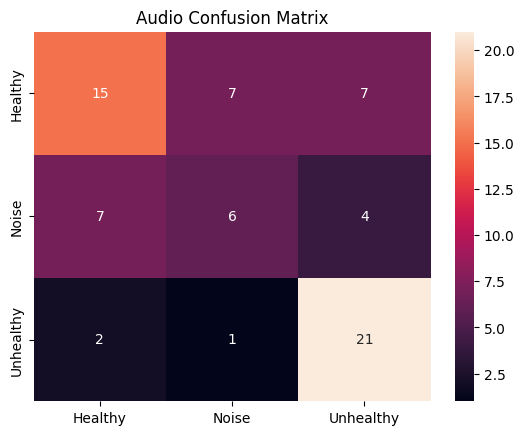

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.62      0.52      0.57        29
       Noise       0.43      0.35      0.39        17
   Unhealthy       0.66      0.88      0.75        24

    accuracy                           0.60        70
   macro avg       0.57      0.58      0.57        70
weighted avg       0.59      0.60      0.59        70



In [ ]:
evaluate_model(baseline_model, test_load, classes)

### Moddified

Moddified model ini dibuat dengan pemikiran bahwa model sebelumnya itu overfit terhadap train datanya dimana model terlalu cepat untuk belajar atau memahami data train tersebut dan tetap berada pada data train tersebut.

In [46]:
class ModdifiedModel(nn.Module):
  def __init__(self, num_classes=3):
    super(ModdifiedModel, self).__init__()

    self.features = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(32, 64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(64, 128, kernel_size=3),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2),
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(25088, 256),
        nn.Dropout(0.5),
        nn.ReLU(),
        nn.Linear(256, num_classes)
    )

  def forward(self, x):
    x = self.features(x)
    return self.classifier(x)

In [47]:
moddified_model = ModdifiedModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(moddified_model.parameters(), lr=0.001)

In [ ]:
moddified_model.to(device)
train_function(moddified_model, train_load, criterion, optimizer, epochs=30)

Epoch 1 | Loss: 57.5603 | Acc: 53.99%
Epoch 2 | Loss: 24.5221 | Acc: 56.16%
Epoch 3 | Loss: 15.5628 | Acc: 61.59%
Epoch 4 | Loss: 9.4286 | Acc: 69.93%
Epoch 5 | Loss: 6.7013 | Acc: 66.67%
Epoch 6 | Loss: 5.6573 | Acc: 75.36%
Epoch 7 | Loss: 5.2058 | Acc: 75.36%
Epoch 8 | Loss: 4.8427 | Acc: 76.09%
Epoch 9 | Loss: 4.1572 | Acc: 82.25%
Epoch 10 | Loss: 3.9878 | Acc: 82.61%
Epoch 11 | Loss: 4.0012 | Acc: 82.97%
Epoch 12 | Loss: 4.0641 | Acc: 84.06%
Epoch 13 | Loss: 3.3593 | Acc: 87.32%
Epoch 14 | Loss: 3.0082 | Acc: 88.41%
Epoch 15 | Loss: 2.7634 | Acc: 90.58%
Epoch 16 | Loss: 2.1890 | Acc: 89.49%
Epoch 17 | Loss: 1.9809 | Acc: 92.39%
Epoch 18 | Loss: 2.2179 | Acc: 92.03%
Epoch 19 | Loss: 2.0255 | Acc: 91.30%
Epoch 20 | Loss: 1.7252 | Acc: 93.12%
Epoch 21 | Loss: 1.7223 | Acc: 92.75%
Epoch 22 | Loss: 1.4464 | Acc: 94.93%
Epoch 23 | Loss: 1.1830 | Acc: 96.01%
Epoch 24 | Loss: 1.0298 | Acc: 96.74%
Epoch 25 | Loss: 1.2127 | Acc: 94.93%
Epoch 26 | Loss: 1.0536 | Acc: 95.65%
Epoch 27 | Loss: 1

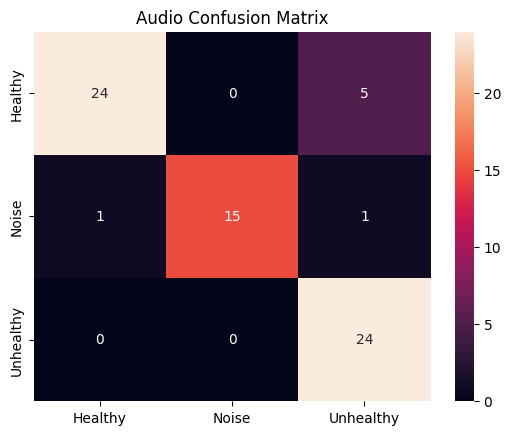

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.96      0.83      0.89        29
       Noise       1.00      0.88      0.94        17
   Unhealthy       0.80      1.00      0.89        24

    accuracy                           0.90        70
   macro avg       0.92      0.90      0.91        70
weighted avg       0.91      0.90      0.90        70



In [ ]:
evaluate_model(moddified_model, test_load, classes)

## Extract best Model

In [ ]:
#Simpan Weight pada model
torch.save(moddified_model.state_dict(), 'Chiken_CNN_Disease_Detection_Model.pth')

## Try model

In [48]:
ModdifiedModel()

ModdifiedModel(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=25088, out_features=256, bias=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): ReLU()
    (4): Linear(in

In [49]:
model = ModdifiedModel(num_classes=3)
model.load_state_dict(torch.load(f'{main_path}/models/vocalization_disease_detection/Chiken_CNN_Disease_Detection_Model.pth'))
model.eval()

ModdifiedModel(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=25088, out_features=256, bias=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): ReLU()
    (4): Linear(in

In [57]:
test_data_path = f'{main_path}/data/processed/audio_test.mp3'
wav, X = audio_to_log_mel_spec(test_data_path)
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
X_tensor = X_tensor.to(device)

model.to(device)

with torch.no_grad():
    output = model(X_tensor)

pred_class = torch.argmax(output, dim=1).item()

class_labels = {0: 'Healthy', 1: 'Noise', 2: 'Unhealthy'}
print(f"Predicted class: {class_labels[pred_class]}")

Predicted class: Healthy


In [58]:
print("Probability pada tiap kelas:")
for i, prob in enumerate(F.softmax(output, dim=1)[0]):
    print(f"{class_labels[i]}: {prob.item() * 100:.2f}%")

Probability pada tiap kelas:
Healthy: 77.60%
Noise: 0.79%
Unhealthy: 21.60%
